In [11]:
from keras.datasets import cifar100    
from models.utils import ResNet18, split_dataframe, detect_drifts
from scipy.io import loadmat
import keras
import numpy as np
import models.unmasking_drift_detector as unm
import models.d3_drift_detector as d3
import matplotlib.pyplot as plt


# load the main dataset
svhn_data = loadmat('train_32x32.mat')
svhn_images, svhn_labels = svhn_data['X'], svhn_data['y']
svhn_images = np.moveaxis(svhn_images, -1, 0)
svhn_labels -= 1  # normally, svhn labels range from 1 to 10, so we solve this issue for later

# select only the images that correspond to the first 5 labels
train_indices = np.where(np.isin(svhn_labels, range(5)))[0]

# define a cap so that we can choose just a percentage of the whole data to train/validate the neural network
cap = len(train_indices)

# split the dataset in train/test values
idx = int(0.8 * cap)
X_train, X_test = svhn_images[train_indices][:idx], svhn_images[train_indices][idx:]
y_train, y_test = svhn_labels[train_indices][:idx], svhn_labels[train_indices][idx:]


In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37826, 32, 32, 3), (9457, 32, 32, 3), (37826, 1), (9457, 1))

In [13]:
# Initialize, compile and fit the ResNet18 neural network
model = ResNet18(input_shape=(32, 32, 3), n_classes=50)
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=3, validation_data=(X_test, y_test))


Epoch 1/3
592/592 [==============================] - 562s 943ms/step - loss: 0.5388 - accuracy: 0.8189 - val_loss: 0.7548 - val_accuracy: 0.7368
Epoch 2/3
592/592 [==============================] - 570s 963ms/step - loss: 0.3054 - accuracy: 0.8986 - val_loss: 0.3838 - val_accuracy: 0.8668
Epoch 3/3
592/592 [==============================] - 577s 975ms/step - loss: 0.2323 - accuracy: 0.9237 - val_loss: 0.3995 - val_accuracy: 0.8571


In [22]:


# define the unseen data as the images corresponding to the last 50 labels. 
# these images were not used to fit the model.
unseen_data_indices = np.where(np.isin(svhn_labels, range(5, 10)))[0]
unseen_data = svhn_images[unseen_data_indices]


# Next, we generate drift over the dataset.
# The drifted dataset will have alternating batches of unseen_data and X_train
# The length of each batch is also flexible
drifted_data = np.empty((0, 32, 32, 3))
i = 0
last_index = 0
current_index = 0
ground_truth_drifts = []

dimension_limit = 0.7 * svhn_images.shape[0]
while drifted_data.shape[0] < dimension_limit:
    if i % 2 == 0:
        current_index += np.random.choice([400, 800, 1200, 1600])
        if i != 0:
            ground_truth_drifts.append(drifted_data.shape[0])
        known_batch = X_train[last_index:current_index]
        drifted_data = np.concatenate((drifted_data, known_batch), axis=0)
    else:
        ground_truth_drifts.append(drifted_data.shape[0])
        batch = unseen_data[last_index:current_index]
        np.random.shuffle(batch)
        drifted_data = np.concatenate((drifted_data, batch), axis=0)
        last_index = current_index
    i += 1


In [23]:
drifted_data.shape, ground_truth_drifts

((51974, 32, 32, 3),
 [1200,
  2400,
  2800,
  3200,
  4400,
  5600,
  6800,
  8000,
  8400,
  8800,
  9600,
  10400,
  11200,
  12000,
  13600,
  15200,
  16000,
  16800,
  17200,
  17600,
  18000,
  18400,
  18800,
  19200,
  20400,
  21600,
  23200,
  24800,
  25600,
  26400,
  26800,
  27200,
  28400,
  29600,
  30400,
  31200,
  32800,
  34400,
  34800,
  35200,
  36800,
  38400,
  39200,
  40000,
  41600,
  43200,
  43600,
  44000,
  45200,
  46400,
  46800,
  47200,
  48800,
  50400,
  51200])

In [24]:
# create an auxiliary model so we can extract data from the avg_pool layer of the already trained neural network
# extract features from the drifted dataset
extract_features_model = keras.Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
features = extract_features_model.predict(drifted_data)

1625/1625 [==============================] - 22s 13ms/step


In [25]:
# split the dataset in reasonable sized batches
# modify the true drifts so that they are assigned to the current batches
batch_size = 400
data_splitted = split_dataframe(features, batch_size)
ground_truth_drifts_batch = np.array(ground_truth_drifts) / batch_size
ground_truth_drifts_batch = ground_truth_drifts_batch.astype(int)

In [26]:
ground_truth_drifts_batch

array([  3,   6,   7,   8,  11,  14,  17,  20,  21,  22,  24,  26,  28,
        30,  34,  38,  40,  42,  43,  44,  45,  46,  47,  48,  51,  54,
        58,  62,  64,  66,  67,  68,  71,  74,  76,  78,  82,  86,  87,
        88,  92,  96,  98, 100, 104, 108, 109, 110, 113, 116, 117, 118,
       122, 126, 128])

Unmasking:
Threshold = 0.5
0.873015873015873
Threshold = 0.52
0.9821428571428571
Threshold = 0.53
0.9821428571428571
Threshold = 0.54
1.0
Threshold = 0.55
1.0
Threshold = 0.56
1.0
Threshold = 0.57
0.9636363636363636
Threshold = 0.58
0.8909090909090909
Threshold = 0.6
0.509090909090909


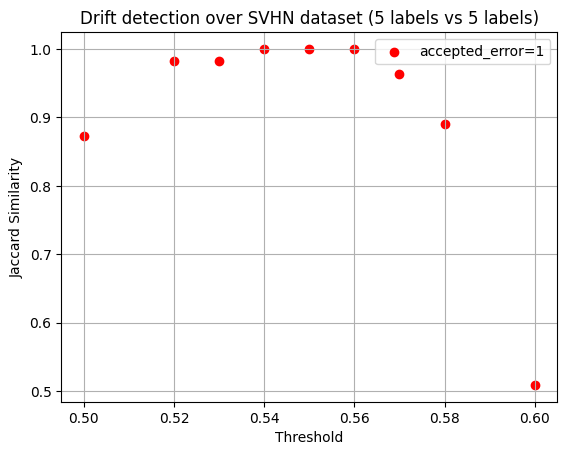

In [32]:
# Perform grid search over the unmasking algorithm.
thresholds = [0.5, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.6]
jaccard_sim_unm = []

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)


# Plot the results
plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN dataset (5 labels vs 5 labels)')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
plt.grid()
plt.legend()
plt.savefig('/images/svhn_itself_jaccard_thresholds_error1.png')
plt.show()

In [3]:
# # Detect drifts using D3 algorithm
# print("D3:")
# sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=True)
# print(sim_d3) # similarity 1.0